## Carga y homogeneización de los datos
    * Los activos no tienen los mismos días cotizados. Explica el enfoque para resolverlo.
    * Hay varios días en los que la mayoría de los activos no tienen corización. Explica el enfoque para resolverlo.
    * ¿Cuantos filas tiene tu DF limpio y homogeneizado?, ¿con cuántos activos os quedáis y por qué?

## Simulaciones
    * ¿Cuantas simulaciones vas a realizar? ten presente que trabajas con muchos activos
    * ¿Cómo generas los números aleatorios y cuantos generas? 60.000 activos * 50.000 simulaciones son 3.000 millones de num (más de 10 gb pickle) y 50.000 simulaciones no son suficientes para la cantidad de activos con la que estamos trabajando...
    * ¿Cuantos activos seleccionas en cada simulación para darles peso?, ¿Cómo los seleccionas? 
    * ¿Cómo asignas el peso a los activos seleccionados?

In [2]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import *
import random
from time import time
from matplotlib import pyplot as plt

## Cargamos los datos y los homogeneizamos

In [2]:
def cargar_ficheros():
    
    onlyfiles = [f for f in listdir('Datos') if isfile(join('Datos', f))]

    datos = []

    for fichero in onlyfiles:

        # print(join('Datos', fichero))    
        df = pd.read_csv(join('Datos', fichero))    
        datos.append(df)

    datos = pd.concat(datos)
    return datos

In [170]:
def comprobar_homogeneizacion(datos):

    # Comprobamos si todos los activos tienen cotizaciones todos los días

    long_fechas_unicas = datos.date.unique().shape[0]
    long_isin_unicos = datos.iloc[:,2].unique().shape[0]

    if (long_fechas_unicas * long_isin_unicos == datos.shape[1]) == True:
        print("Los activos están homogeneizados")
        return True
    else:
        print("Los activos NO están homogeneizados")
        return False    
    

In [91]:
def extraccion_datos(isin, datos):
    
    # Localizo los datos
    df_intermedio = datos.loc[datos["isin"]==isin,:]

    # Genero un nuevo DF solo con los datos que nos interesan:
    # Fecha como index y nav, siendo el isin el nombre de la columna.
    nuevo_df = pd.DataFrame(df_intermedio, columns=["date","nav"])
    
    # Hay isins con fechas repetidas
    nuevo_df = nuevo_df.groupby('date').first().reset_index()      
    
    nuevo_df.index = nuevo_df.date  
    nuevo_df.index = pd.to_datetime(nuevo_df.index)    
    del nuevo_df["date"]
    nuevo_df.columns = [isin]
    
    return nuevo_df

In [172]:
def homogeizar(datos):

    lista_isin = datos.iloc[:,2].unique()

    fechas_posibles = datos.date.unique()
    fechas_posibles.sort()
    fechas_posibles = pd.date_range(fechas_posibles[0], fechas_posibles[-1], freq=BDay())
    datos_ordenados = pd.DataFrame(columns=[""], index = fechas_posibles) 

    for isin in lista_isin:

        print(isin)
        isin_extraido = extraccion_datos(isin, datos)

        # La gran mayoría tiene más de 200 días, pero hay varios con menos de 100 datos
        # Debemos filtrar los activos para poder trabajar

        if (isin_extraido.shape[0] > fechas_posibles.shape[0]*0.7):

            datos_ordenados = pd.concat([datos_ordenados, isin_extraido], axis=1) # alternativa datos_ordenados = datos_ordenados.join(isin_extraido)

    datos_ordenados = datos_ordenados.drop(columns='')

    # Encontramos las filas donde un % elevado son Nan y las eliminamos
    dias_eliminar = ~(datos_ordenados.isna().sum(axis=1) > datos_ordenados.shape[1]*0.9)
    datos_ordenados = datos_ordenados.loc[dias_eliminar,:]

    # Completamos los Nan con los datos del día anterior
    datos_ordenados = datos_ordenados.fillna(method='ffill')

    # Aquellos valores que no tienen un primer día cotizado, el método anterior no sirve
    datos_ordenados = datos_ordenados.fillna(method='bfill')

    datos_ordenados.to_pickle("datos_ordenados.pkl")     
    
    return datos_ordenados

## Analizamos cómo generar los pesos de las carteras

In [63]:
num_activos = datos_ordenados.shape[1]
simulaciones = 50000

# Este es el sistema más rápido para generar números aleatorios en python
aleatorios = np.random.randint(low=1, high=100, size=num_activos * simulaciones)
aleatorios = aleatorios.reshape((simulaciones, num_activos))

# Localizamos en cada fila aquellos números que superan un umbral
umbral = 98

aleatorios[aleatorios<umbral] = 0
aleatorios[aleatorios>=umbral] = 1

print(aleatorios.sum(axis=1)) # Sacando así los números aleatorios, cada fila tiene más de 1000 activos seleccionados (este sistema no nos vale)

# aleatorios = pd.DataFrame(aleatorios)
# aleatorios.to_pickle("aleatorios.pkl")  # Guardar los aleatorios es una mala idea, 50.000 simulaciones ocupan 10 GB

[1192 1221 1165 ... 1184 1176 1159]


In [4]:
# Comparamos el tiempo entre generar números aleatorios y reordenar los existentes

num_activos = datos_ordenados.shape[1]
simulaciones = 50000

# Generamos números aleatorios
start_time = time()
aleatorios = np.random.randint(low=1, high=100, size=num_activos * simulaciones)
aleatorios = aleatorios.reshape((simulaciones, num_activos))
elapsed_time = time() - start_time
print(elapsed_time)

# Reordenamos los existentes
start_time = time()
np.random.shuffle(np.transpose(aleatorios))
elapsed_time = time() - start_time
print(elapsed_time)

# Evidentemente es mejor generar nuevos números aleatorios

17.542607069015503
136.80407285690308


In [76]:
# Debemos probar otra manera de sacar números aleatorios (cada simulación debería tener entre 2 y 20 activos)

num_activos = datos_ordenados.shape[1]
simulaciones = 10000
        
# Experimento A: Sacar números entre 1 y el número de columnas
    # Podemos sacar simulaciones de 50.000 y es la manera más rápida
    # El umbral no nos permite obtener unos pocos activos en cada simulación

start_time = time()

print("Experimento A: Sacar números entre 1 y el número de columnas")
aleatorios = np.random.randint(low=1, high=num_activos, size=num_activos * simulaciones)
aleatorios = aleatorios.reshape((simulaciones, num_activos))

umbral = num_activos * 0.99
aleatorios[aleatorios<umbral] = 0
aleatorios[aleatorios>=umbral] = 1

print(aleatorios.sum(axis=1))
elapsed_time = time() - start_time
print(elapsed_time)

# Experimento B: Sacar números entre 0 y 1
    # Podemos sacar 10.000 simulaciones (no 50.000) y es más lento que randint
    # Pero el umbral nos permite obtener unos pocos activos en cada simulación
    # Nos quedamos con el experimento B
    
print("")
start_time = time()

print("Experimento B: Sacar números entre 0 y 1")
aleatorios = np.random.random((simulaciones,num_activos))

umbral = 0.9999
aleatorios[aleatorios<umbral] = 0
aleatorios[aleatorios>=umbral] = 1

print(aleatorios.sum(axis=1))
elapsed_time = time() - start_time
print(elapsed_time)


Experimento A: Sacar números entre 1 y el número de columnas
[628 553 555 ... 574 574 582]
4.581849813461304

Experimento B: Sacar números entre 0 y 1
[1. 7. 5. ... 6. 7. 4.]
5.076435804367065


In [3]:
def generador_pesos(datos_ordenados, simulaciones = 10000):

    num_activos = datos_ordenados.shape[1]
    aleatorios = np.random.random((simulaciones,num_activos))

    umbral = 0.9998
    aleatorios[aleatorios<umbral] = 0

    # Buscamos y eliminamos las simulaciones que no tienen ningún activo seleccionado
    seleccion = ~(aleatorios.sum(axis=1) == 0)
    aleatorios = aleatorios[seleccion,:]

    # Asignamos los pesos a cada cartera
    # Para poder usar los aleatorios, dado que todos los activos seleccionados superan un umbral, debo restar el umbral
    # Si reescalase el peso, ningún activo de una cartera de 3 elementos superaría el 50% - 60% de peso. No puedo asignar los pesos reescalando.
    aleatorios[aleatorios!=0] = (aleatorios[aleatorios!=0] - umbral) * 10000

    for sim in range(aleatorios.shape[0]):

        vector_pesos = aleatorios[sim,:]    
        posiciones = set(np.where(vector_pesos!=0)[0])

        # Obtenemos el órden en el que vamos a asignar los pesos
        posiciones_aleatorias = random.sample(posiciones, len(posiciones))

        peso = 0
        for pos in posiciones_aleatorias:
            if peso < 1:
                peso += aleatorios[sim, pos]

                if peso > 1:            
                    exceso = peso - 1
                    aleatorios[sim, pos] = aleatorios[sim, pos] - exceso
                    peso = 1            

            elif peso == 1:
                aleatorios[sim, pos] = 0
    
    # En las carteras con 1 o 2 activos, no van a sumar siempre un 100% invertido. 
    # De cada 10.000 simulaciones, con un umbral de 0.9999 ocurre 600 - 700 veces. 
    # Con un unbral de 0.9998 de 1 a 5 veces.
    # Lo damos por bueno.
    
    return aleatorios
    

In [185]:
start_time = time()

pesos_carteras = generador_pesos(datos_ordenados, simulaciones = 10000)

elapsed_time = time() - start_time
print(elapsed_time)

7.086063385009766


## Calculamos la frontera de Markowitz

In [21]:
def frontera_markowitz(num_simulaciones=100000):

    # Cargamos los datos
    try:
        datos_ordenados = pd.read_pickle("datos_ordenados.pkl")

    except:
        datos = cargar_ficheros()
        comprobacion = comprobar_homogeneizacion(datos)

        if comprobacion == False:
            datos_ordenados = homogeizar(datos)

    # Inicializamos el valor de la cartera más eficiente y preparamos el gráfico de la frontera
    eficiencia_inicial = -100
    plt.figure(figsize=(20,15))    

    # Calculamos la rentabilidad de los activos
    rent_activos = np.log(datos_ordenados).diff() 
    rent_activos = rent_activos.iloc[1:,:]

    # Calculamos la matriz de correlaciones
    #try:
    #    matriz_correlaciones = pd.read_pickle("matriz_correlaciones.pkl")
    #except:
    #    matriz_correlaciones = rent_activos.corr()
    #    matriz_correlaciones.to_pickle("matriz_correlaciones.pkl") # EL pickle ocupa 25,4 GB

    # Calculamos la matriz de varianzas / covarianzas
    matriz_covarianzas = rent_activos.cov()
    matriz_covarianzas = matriz_covarianzas.to_numpy(dtype='float') 

    # Calculamos la rentabilidad diaria del periodo para cada activo: LN(precio final/ precio inicial)/nº de datos
    precio_inicial = datos_ordenados.iloc[0,:]
    precio_final = datos_ordenados.iloc[-1,:]

    rentabilidad_diaria = np.log(precio_final / precio_inicial) / datos_ordenados.shape[0]

    num_bloques = int(np.ceil(num_simulaciones/10000))
    for bloque in range(num_bloques):

        # Sacamos la matriz de pesos para cada cartera
        matriz_pesos = generador_pesos(datos_ordenados, simulaciones = 10000)

        # Calculamos la rentabilidad de la cartera en función de los pesos 
        auxiliar = rentabilidad_diaria.values * matriz_pesos
        rentabilidad_carteras = auxiliar.sum(axis=1)

        # Calculamos el riesgo de la cartera (desviación), en función de los pesos
        auxiliar = np.dot(matriz_pesos, matriz_covarianzas) # Reutilizo la matriz auxiliar con otro propósito para no sobrecargar la RAM
        riesgo_carteras = pow((auxiliar * matriz_pesos).sum(axis=1), 0.5)

        # Hay que quitar outlayers: quantiles max de riesgo y quantiles minimos de rentabilidad
        filtro_riesgo = riesgo_carteras < np.percentile(riesgo_carteras, 99)
        riesgo_carteras = riesgo_carteras[filtro_riesgo]
        rentabilidad_carteras = rentabilidad_carteras[filtro_riesgo]

        filtro_rentabilidad = rentabilidad_carteras > np.percentile(rentabilidad_carteras, 1)
        riesgo_carteras = riesgo_carteras[filtro_rentabilidad]
        rentabilidad_carteras = rentabilidad_carteras[filtro_rentabilidad]

        # Calculamos la eficiencia de la cartera (pendiente), en función de los pesos
        # Existen posiciones que van a dar error, 0/0. Las localizo y hago que 0/1 = 0
        posiciones_0entre0 = (rentabilidad_carteras==0) * (riesgo_carteras==0)
        riesgo_carteras[posiciones_0entre0] = 0.0000001
        eficiencia_carteras = rentabilidad_carteras / riesgo_carteras

        # Localizamos la cartera con mayor eficiencia
        max_eficiencia = max(eficiencia_carteras)

        if max_eficiencia > eficiencia_inicial:

            posicion_cartera_eficiente = np.where(eficiencia_carteras == max_eficiencia)[0]
            cartera_eficiente = matriz_pesos[posicion_cartera_eficiente,:]    
            posicion_activos_eficientes = np.where(cartera_eficiente!=0)

            peso_activos_eficientes = cartera_eficiente[posicion_activos_eficientes]            
            isin_activos_eficientes = rent_activos.columns.values[posicion_activos_eficientes[1]]            
            eficiencia_inicial = max_eficiencia

        # Graficamos la frontera de Markowitz (riesgo y rentabilidad para cada vector de pesos)
        print(f'Iteracion {bloque+1} de {num_bloques}')
        plt.plot(riesgo_carteras,rentabilidad_carteras, 'o', color="b")

    # Dejamos bonito el gráfico y ajustamos la escala, para ver bien la frontera.
    plt.xlabel("Riesgo")
    plt.ylabel("Rentabilidad")

    scale_factor = 3
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin * scale_factor, xmax * scale_factor)
    plt.ylim(ymin * scale_factor/2, ymax * scale_factor/2)
    plt.savefig('frontera_markowitz.png')

    return isin_activos_eficientes, peso_activos_eficientes, max_eficiencia

Iteracion 1 de 500
Iteracion 2 de 500
Iteracion 3 de 500
Iteracion 4 de 500
Iteracion 5 de 500
Iteracion 6 de 500
Iteracion 7 de 500
Iteracion 8 de 500
Iteracion 9 de 500
Iteracion 10 de 500
Iteracion 11 de 500
Iteracion 12 de 500
Iteracion 13 de 500
Iteracion 14 de 500
Iteracion 15 de 500
Iteracion 16 de 500
Iteracion 17 de 500
Iteracion 18 de 500
Iteracion 19 de 500
Iteracion 20 de 500
Iteracion 21 de 500
Iteracion 22 de 500
Iteracion 23 de 500
Iteracion 24 de 500
Iteracion 25 de 500
Iteracion 26 de 500
Iteracion 27 de 500
Iteracion 28 de 500
Iteracion 29 de 500
Iteracion 30 de 500
Iteracion 31 de 500
Iteracion 32 de 500
Iteracion 33 de 500
Iteracion 34 de 500
Iteracion 35 de 500
Iteracion 36 de 500
Iteracion 37 de 500
Iteracion 38 de 500
Iteracion 39 de 500
Iteracion 40 de 500
Iteracion 41 de 500
Iteracion 42 de 500
Iteracion 43 de 500
Iteracion 44 de 500
Iteracion 45 de 500
Iteracion 46 de 500
Iteracion 47 de 500
Iteracion 48 de 500
Iteracion 49 de 500
Iteracion 50 de 500
Iteracion

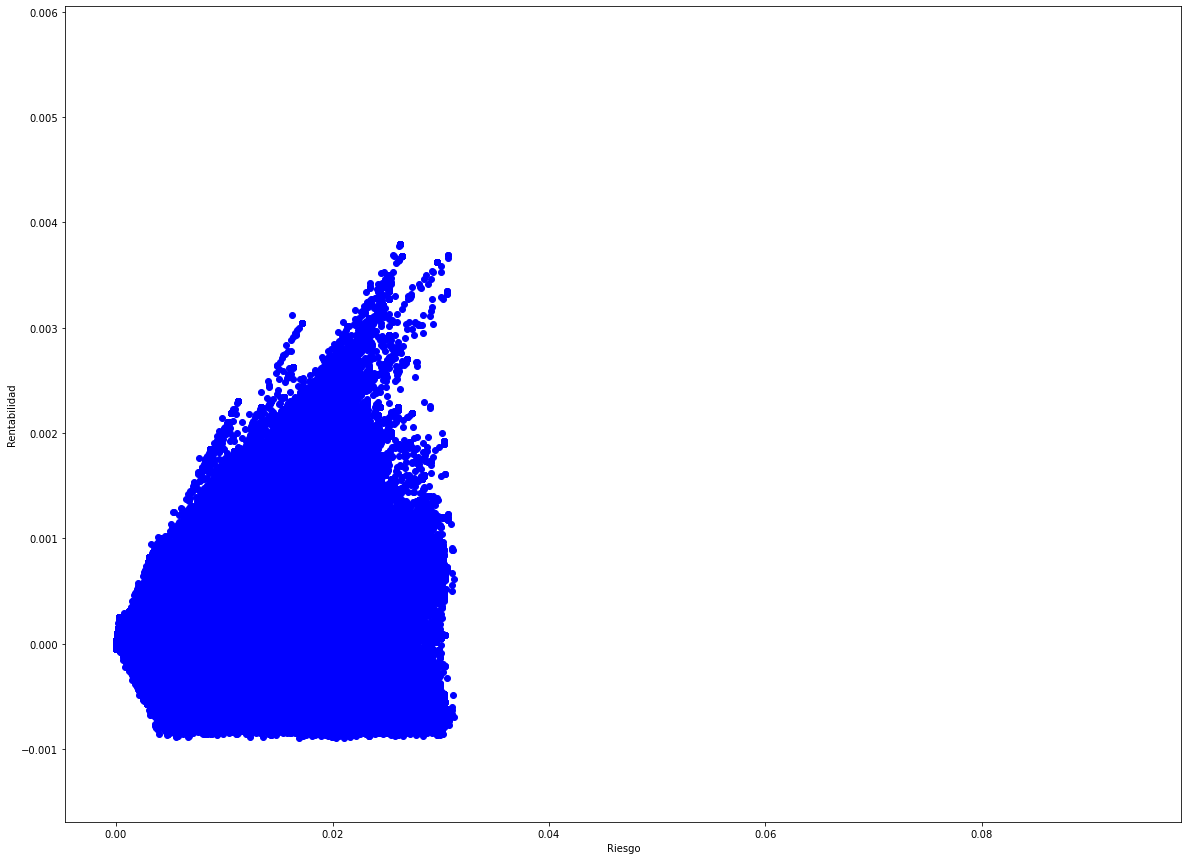

In [22]:
isin_activos_eficientes, peso_activos_eficientes, max_eficiencia = frontera_markowitz(num_simulaciones = 5000000)

print(isin_activos_eficientes)
print(peso_activos_eficientes)
print(max_eficiencia)